In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ak-new-cycle/Preprocessed_Output/0035/EO_RGB_NIR.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0035/SAR.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0035/EO_NIR_SWIR_RE.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0035/EO_RGB.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0020/EO_RGB_NIR.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0020/SAR.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0020/EO_NIR_SWIR_RE.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0020/EO_RGB.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0041/EO_RGB_NIR.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0041/SAR.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0041/EO_NIR_SWIR_RE.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0041/EO_RGB.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0024/EO_RGB_NIR.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0024/SAR.pt
/kaggle/input/ak-new-cycle/Preprocessed_Output/0024/EO_NIR_SWIR_RE.pt
/kaggle/input/ak-new-cycle/Preproc

In [1]:
import os
import torch
from torch.utils.data import Dataset

# Custom PyTorch Dataset for loading paired SAR and EO (RGB) satellite images
class SAREODataset(Dataset):
    def __init__(self, root_dir, sar_key="SAR.pt", eo_key="EO_RGB.pt", transform=None):
        # root_dir: list of directories where data samples are stored
        # sar_key: filename for SAR data (default: "SAR.pt")
        # eo_key: filename for EO data (default: "EO_RGB.pt")
        # transform: optional transform to apply to each tensor (e.g., augmentation)
        
        # Filter out directories that don't contain both SAR and EO files
        self.root_dir = [
            d for d in root_dir
            if os.path.exists(os.path.join(d, sar_key)) and os.path.exists(os.path.join(d, eo_key))
        ]
        self.sar_key = sar_key  # store SAR file name
        self.eo_key = eo_key    # store EO file name
        self.transform = transform  # store transform function (if any)

    def __len__(self):
        # Return the number of valid samples (directories with both SAR and EO)
        return len(self.root_dir)

    def normalize(self, x):
        # Normalize tensor values to range [-1, 1]
        return 2 * (x - x.min()) / (x.max() - x.min() + 1e-8) - 1

    def __getitem__(self, idx):
        # Get a single sample (SAR + EO pair) by index
        sample_path = self.root_dir[idx]  # path to the selected sample directory

        # Load SAR data tensor from disk (expected shape: [2, H, W])
        sar = torch.load(os.path.join(sample_path, self.sar_key))
        # Load EO (RGB) data tensor from disk (expected shape: [3, H, W])
        eo_rgb = torch.load(os.path.join(sample_path, self.eo_key))

        # Normalize both SAR and EO tensors to [-1, 1]
        sar = self.normalize(sar)
        eo_rgb = self.normalize(eo_rgb)

        # If a transform is provided (e.g., random crop, flip), apply it to both tensors
        if self.transform:
            sar = self.transform(sar)
            eo_rgb = self.transform(eo_rgb)

        # Return a dictionary containing both SAR and EO tensors
        return {"SAR": sar, "EO_RGB": eo_rgb}


In [2]:
from sklearn.model_selection import train_test_split
import glob
from torch.utils.data import DataLoader

all_samples = sorted(glob.glob("/kaggle/input/ak-new-cycle/Preprocessed_Output/*"))

train_paths, val_paths = train_test_split(all_samples, test_size=0.2, random_state=42)

train_dataset = SAREODataset(root_dir=train_paths)
val_dataset = SAREODataset(root_dir=val_paths)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [3]:
for data in train_loader:
    eo_rgb = data['EO_RGB']
    sar=data["SAR"]
    print(eo_rgb.shape)
    print(sar.shape )
    break

torch.Size([1, 3, 256, 256])
torch.Size([1, 2, 256, 256])


In [4]:
# EO_RGB
eo_rgb = eo_rgb.float()  # ensure it's float for accurate min/max
eo_min = eo_rgb.min().item()
eo_max = eo_rgb.max().item()
print(f"EO_RGB range: min = {eo_min}, max = {eo_max}")

# SAR
sar = sar.float()
sar_min = sar.min().item()
sar_max = sar.max().item()
print(f"SAR range: min = {sar_min}, max = {sar_max}")

EO_RGB range: min = -1.0, max = 1.0
SAR range: min = -1.0, max = 0.9999998807907104


In [34]:
eo_rgb_sample = eo_rgb[0]  # shape: [3, H, W]
print(f"Min: {eo_rgb_sample.min().item()}, Max: {eo_rgb_sample.max().item()}")

Min: -1.0, Max: 1.0


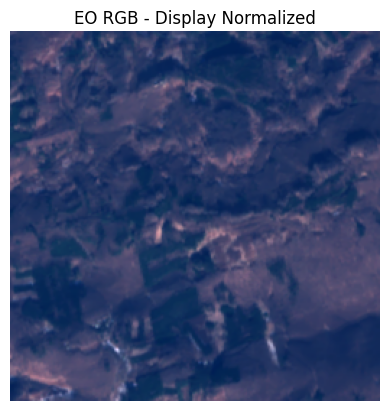

In [36]:
def normalize_for_display(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

eo_rgb_sample = normalize_for_display(eo_rgb[0])
plt.imshow(TF.to_pil_image(eo_rgb_sample))
plt.title("EO RGB - Display Normalized")
plt.axis("off")
plt.show()

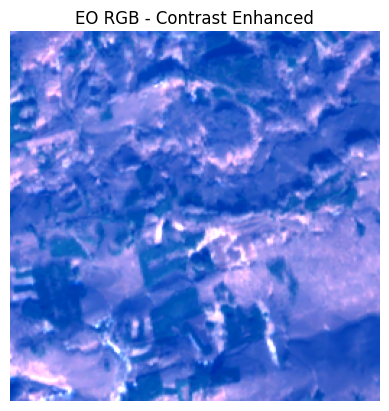

In [37]:
def contrast_stretch(img):
    p2 = torch.quantile(img, 0.02)
    p98 = torch.quantile(img, 0.98)
    return torch.clamp((img - p2) / (p98 - p2 + 1e-8), 0, 1)

eo_rgb_sample = contrast_stretch(eo_rgb[0])
plt.imshow(TF.to_pil_image(eo_rgb_sample))
plt.title("EO RGB - Contrast Enhanced")
plt.axis("off")
plt.show()

In [3]:
import torch
import torch.nn as nn

# -----------------------------
# Residual block (used inside the generator)
# -----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # A residual block consists of two 3x3 convolutions with InstanceNorm and ReLU (first only)
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),  # pad to keep spatial dimensions
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),  # conv layer
            nn.InstanceNorm2d(dim),  # normalization for stable training
            nn.ReLU(inplace=True),  # activation

            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),  # another conv
            nn.InstanceNorm2d(dim)  # normalization (no ReLU here)
        )

    def forward(self, x):
        # Add input (skip connection) to the block output — residual connection
        return x + self.block(x)


# -----------------------------
# ResNet-based Generator (for CycleGAN-like architectures)
# -----------------------------
class GeneratorResNet(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super().__init__()

        # -----------------
        # Initial convolution layer
        # -----------------
        model = [
            nn.ReflectionPad2d(3),  # pad to keep dimensions
            nn.Conv2d(input_nc, 64, kernel_size=7, stride=1, padding=0),  # 7x7 conv
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # -----------------
        # Downsampling layers (reduce spatial size, increase channels)
        # -----------------
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):  # two downsampling steps
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),  # strided conv
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # -----------------
        # Residual blocks (core of the ResNet generator)
        # -----------------
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]  # add residual blocks

        # -----------------
        # Upsampling layers (increase spatial size, reduce channels)
        # -----------------
        out_features = in_features // 2
        for _ in range(2):  # two upsampling steps
            model += [
                nn.ConvTranspose2d(
                    in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1
                ),  # transpose conv for upsampling
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # -----------------
        # Output layer (convert to final number of channels)
        # -----------------
        model += [
            nn.ReflectionPad2d(3),  # pad before final conv
            nn.Conv2d(64, output_nc, kernel_size=7),  # 7x7 conv for output
            nn.Tanh()  # output in range [-1,1]
        ]

        # Wrap entire model as a single nn.Sequential
        self.model = nn.Sequential(*model)

    def forward(self, x):
        # Forward pass through the network
        return self.model(x)


In [4]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

# -----------------------------
# PatchGAN Discriminator
# -----------------------------
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        # Helper function: a single conv → norm → LeakyReLU block
        def conv_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1),  # 4x4 conv
                nn.InstanceNorm2d(out_channels),  # normalization for stability
                nn.LeakyReLU(0.2, inplace=True)   # leaky relu (slope 0.2)
            )

        # Sequential layers of the PatchGAN discriminator
        self.model = nn.Sequential(
            # First layer: conv + LeakyReLU (no normalization in first layer, as per CycleGAN paper)
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsampling layers
            conv_block(64, 128, stride=2),
            conv_block(128, 256, stride=2),

            # Deeper features but with stride=1 for finer patch-level discrimination
            conv_block(256, 512, stride=1),

            # Final conv: produce a 1-channel "patch map" of real/fake scores
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        # Forward pass: returns a feature map of "realness" per patch
        return self.model(x)

In [6]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np
import itertools

# Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate generators and discriminators
G_SAR_to_EO = GeneratorResNet(input_nc=2, output_nc=3)  # Generator: SAR → EO
G_EO_to_SAR = GeneratorResNet(input_nc=3, output_nc=2)  # Generator: EO → SAR
D_EO = Discriminator(in_channels=3)  # Discriminator for EO images
D_SAR = Discriminator(in_channels=2)  # Discriminator for SAR images


# -----------------------------
# CycleGAN Trainer Class
# -----------------------------
class CycleGANTrainer:
    def __init__(self, G_SAR_to_EO, G_EO_to_SAR, D_SAR, D_EO, device):
        self.device = device 
        
        # Move all models to device
        self.G_SAR_to_EO = G_SAR_to_EO.to(self.device)
        self.G_EO_to_SAR = G_EO_to_SAR.to(self.device)
        self.D_SAR = D_SAR.to(self.device)
        self.D_EO = D_EO.to(self.device)

        # Loss functions
        self.criterion_GAN = nn.MSELoss()      # GAN loss: least-squares GAN
        self.criterion_cycle = nn.L1Loss()     # Cycle-consistency loss
        self.criterion_identity = nn.L1Loss()  # Identity loss

        # Optimizers
        self.optimizer_G = torch.optim.Adam(
            itertools.chain(G_SAR_to_EO.parameters(), G_EO_to_SAR.parameters()), 
            lr=2e-4, betas=(0.5, 0.999)  # Adam with beta values as in CycleGAN paper
        )
        self.optimizer_D_SAR = torch.optim.Adam(D_SAR.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.optimizer_D_EO = torch.optim.Adam(D_EO.parameters(), lr=2e-4, betas=(0.5, 0.999))

        # Loss weighting factors
        self.lambda_cycle = 10.0     # weight for cycle-consistency loss
        self.lambda_identity = 5.0   # weight for identity loss

    # -----------------------------
    # Training Loop
    # -----------------------------
    def train(self, train_loader, val_loader, num_epochs=10, save_dir="checkpoints"):
        os.makedirs(save_dir, exist_ok=True)  # create directory for saving models

        for epoch in range(num_epochs):
            print(f"\n Epoch {epoch+1}/{num_epochs}")
            self.G_SAR_to_EO.train()
            self.G_EO_to_SAR.train()

            for i, batch in enumerate(train_loader):
                # Load real images
                real_SAR = batch['SAR'].to(self.device)
                real_EO = batch['EO_RGB'].to(self.device)

                # Create "valid" and "fake" labels for GAN training
                valid = torch.ones(real_SAR.size(0), 1, 30, 30).to(self.device)  # PatchGAN real labels
                fake = torch.zeros_like(valid).to(self.device)  # PatchGAN fake labels

                # ---------------------
                #  Train Generators
                # ---------------------
                self.optimizer_G.zero_grad()

                # Generate fake images
                fake_EO = self.G_SAR_to_EO(real_SAR)  # SAR → EO
                fake_SAR = self.G_EO_to_SAR(real_EO)  # EO → SAR

                # GAN losses (want discriminators to predict "real" for generated images)
                loss_GAN_SAR2EO = self.criterion_GAN(self.D_EO(fake_EO), valid)
                loss_GAN_EO2SAR = self.criterion_GAN(self.D_SAR(fake_SAR), valid)

                # Cycle-consistency: reconstruct original images
                rec_SAR = self.G_EO_to_SAR(fake_EO)
                rec_EO = self.G_SAR_to_EO(fake_SAR)
                loss_cycle_SAR = self.criterion_cycle(rec_SAR, real_SAR)
                loss_cycle_EO = self.criterion_cycle(rec_EO, real_EO)

                # Identity loss (encourage generators to preserve images from their own domain)
                same_SAR = self.G_EO_to_SAR(real_EO)  # EO → SAR
                same_EO = self.G_SAR_to_EO(real_SAR)  # SAR → EO
                loss_identity_SAR = self.criterion_identity(same_SAR, real_SAR)
                loss_identity_EO = self.criterion_identity(same_EO, real_EO)

                # Total generator loss
                loss_G = (
                    loss_GAN_SAR2EO + loss_GAN_EO2SAR +
                    self.lambda_cycle * (loss_cycle_SAR + loss_cycle_EO) +
                    self.lambda_identity * (loss_identity_SAR + loss_identity_EO)
                )
                loss_G.backward()
                self.optimizer_G.step()

                # ---------------------
                #  Train Discriminator SAR
                # ---------------------
                self.optimizer_D_SAR.zero_grad()
                loss_real_SAR = self.criterion_GAN(self.D_SAR(real_SAR), valid)
                loss_fake_SAR = self.criterion_GAN(self.D_SAR(fake_SAR.detach()), fake)  # detach to avoid updating G
                loss_D_SAR = 0.5 * (loss_real_SAR + loss_fake_SAR)
                loss_D_SAR.backward()
                self.optimizer_D_SAR.step()

                # ---------------------
                #  Train Discriminator EO
                # ---------------------
                self.optimizer_D_EO.zero_grad()
                loss_real_EO = self.criterion_GAN(self.D_EO(real_EO), valid)
                loss_fake_EO = self.criterion_GAN(self.D_EO(fake_EO.detach()), fake)
                loss_D_EO = 0.5 * (loss_real_EO + loss_fake_EO)
                loss_D_EO.backward()
                self.optimizer_D_EO.step()

                # Print progress every 10 iterations
                if i % 10 == 0:
                    print(f"  Iter {i}: G_loss: {loss_G.item():.4f} | D_SAR: {loss_D_SAR.item():.4f} | D_EO: {loss_D_EO.item():.4f}")

            # Save model checkpoints every 2 epochs
            if (epoch + 1) % 2 == 0:
                torch.save(self.G_SAR_to_EO.state_dict(), f"{save_dir}/G_SAR_to_EO_epoch{epoch+1}.pth")
                torch.save(self.G_EO_to_SAR.state_dict(), f"{save_dir}/G_EO_to_SAR_epoch{epoch+1}.pth")
                torch.save(self.D_SAR.state_dict(), f"{save_dir}/D_SAR_epoch{epoch+1}.pth")
                torch.save(self.D_EO.state_dict(), f"{save_dir}/D_EO_epoch{epoch+1}.pth")

            # Evaluate model after each epoch
            self.evaluate(val_loader)

    # -----------------------------
    # Evaluation: PSNR + SSIM
    # -----------------------------
    def evaluate(self, test_loader):
        self.G_SAR_to_EO.eval()
        total_psnr, total_ssim, count = 0.0, 0.0, 0

        with torch.no_grad():
            for batch in test_loader:
                sar = batch['SAR'].to(self.device)
                real_eo = batch['EO_RGB'].to(self.device)

                fake_eo = self.G_SAR_to_EO(sar)  # SAR → EO

                # Compute metrics per image
                for i in range(sar.size(0)):
                    pred = fake_eo[i].detach().cpu().numpy().transpose(1, 2, 0)
                    target = real_eo[i].detach().cpu().numpy().transpose(1, 2, 0)

                    pred = np.clip(pred, 0, 1)
                    target = np.clip(target, 0, 1)

                    psnr_val = compare_psnr(target, pred, data_range=1.0)
                    ssim_val = compare_ssim(target, pred, channel_axis=-1, data_range=1.0)

                    total_psnr += psnr_val
                    total_ssim += ssim_val
                    count += 1

        # Average metrics
        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count
        print(f" [Test] Avg PSNR: {avg_psnr:.2f} | Avg SSIM: {avg_ssim:.4f}")

        # Visualize some results
        self.visualize(test_loader)

    # -----------------------------
    # Visualize samples
    # -----------------------------
    def visualize(self, test_loader, num_samples=3):
        self.G_SAR_to_EO.eval()
        batch = next(iter(test_loader))
        sar = batch['SAR'][:num_samples].to(self.device)
        real_eo = batch['EO_RGB'][:num_samples].to(self.device)

        with torch.no_grad():
            fake_eo = self.G_SAR_to_EO(sar)  # Generate EO images

        # Helper: show images with matplotlib
        def show_images(tensors, title):
            batch_size = tensors.size(0)
            for i in range(min(batch_size, 3)):
                sample = tensors[i].cpu().numpy()  # shape (C, H, W)
                # If SAR (2 channels), pad to 3 channels for display
                if sample.shape[0] == 2:
                    sample = np.concatenate([sample, np.zeros((1, *sample.shape[1:]))], axis=0)  # (3, H, W)
                sample = np.transpose(sample, (1, 2, 0))  # (H, W, 3)
                plt.imshow(sample)
                plt.title(f"{title} - Sample {i}")
                plt.axis('off')
                plt.show()


Using device: cuda


In [7]:
trainer = CycleGANTrainer(
    G_SAR_to_EO, G_EO_to_SAR, D_SAR, D_EO, device
)

trainer.train(train_loader=train_loader, val_loader=val_loader, num_epochs=20)


 Epoch 1/20
  Iter 0: G_loss: 15.7334 | D_SAR: 0.4639 | D_EO: 0.4590
  Iter 10: G_loss: 7.0693 | D_SAR: 0.2888 | D_EO: 0.3322
  Iter 20: G_loss: 7.5985 | D_SAR: 0.3248 | D_EO: 0.2957
  Iter 30: G_loss: 10.6432 | D_SAR: 0.2566 | D_EO: 0.3050
 [Test] Avg PSNR: 28.40 | Avg SSIM: 0.8816

 Epoch 2/20
  Iter 0: G_loss: 4.9761 | D_SAR: 0.2562 | D_EO: 0.2094
  Iter 10: G_loss: 13.4625 | D_SAR: 0.2688 | D_EO: 0.5897
  Iter 20: G_loss: 7.2250 | D_SAR: 0.2482 | D_EO: 0.2302
  Iter 30: G_loss: 12.4066 | D_SAR: 0.1840 | D_EO: 0.2622
 [Test] Avg PSNR: 30.94 | Avg SSIM: 0.9016

 Epoch 3/20
  Iter 0: G_loss: 7.3749 | D_SAR: 0.2735 | D_EO: 0.1518
  Iter 10: G_loss: 7.3387 | D_SAR: 0.1260 | D_EO: 0.1795
  Iter 20: G_loss: 6.4420 | D_SAR: 0.2366 | D_EO: 0.3136
  Iter 30: G_loss: 10.5564 | D_SAR: 0.1392 | D_EO: 0.2643
 [Test] Avg PSNR: 26.28 | Avg SSIM: 0.8756

 Epoch 4/20
  Iter 0: G_loss: 8.1865 | D_SAR: 0.2016 | D_EO: 0.2176
  Iter 10: G_loss: 6.3744 | D_SAR: 0.1386 | D_EO: 0.1387
  Iter 20: G_loss: 6

In [28]:
import matplotlib.pyplot as plt
import numpy as np                  
import torch

def denormalize(tensor):
    return (tensor + 1) / 2

def visualize_samples(model, val_loader, device='cuda', num_samples=3):
    model.eval()
    model.to(device)

    batch = next(iter(val_loader))
    sar = batch['SAR'].to(device)
    eo_real = batch['EO_RGB'].to(device)

    # Ensure shape: [B, C, H, W]
    if sar.dim() == 3:
        sar = sar.unsqueeze(0)
        eo_real = eo_real.unsqueeze(0)

    sar = sar[:num_samples]
    eo_real = eo_real[:num_samples]

    with torch.no_grad():
        eo_fake = model(sar)

    for i in range(len(sar)):
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))

        # SAR has 2 channels
        sar_ch1 = sar[i, 0].detach().cpu().numpy()
        sar_ch2 = sar[i, 1].detach().cpu().numpy()

        axs[0].imshow(sar_ch1, cmap='gray')
        axs[0].set_title('SAR Channel 1')
        axs[0].axis('off')

        axs[1].imshow(sar_ch2, cmap='gray')
        axs[1].set_title('SAR Channel 2')
        axs[1].axis('off')

        # Real EO
        real_eo = denormalize(eo_real[i]).cpu().permute(1, 2, 0).numpy()
        axs[2].imshow(np.clip(real_eo, 0, 1))
        axs[2].set_title('Real EO')
        axs[2].axis('off')

        # Generated EO
        fake_eo = denormalize(eo_fake[i]).cpu().permute(1, 2, 0).numpy()
        axs[3].imshow(np.clip(fake_eo, 0, 1))
        axs[3].set_title('Generated EO')
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()


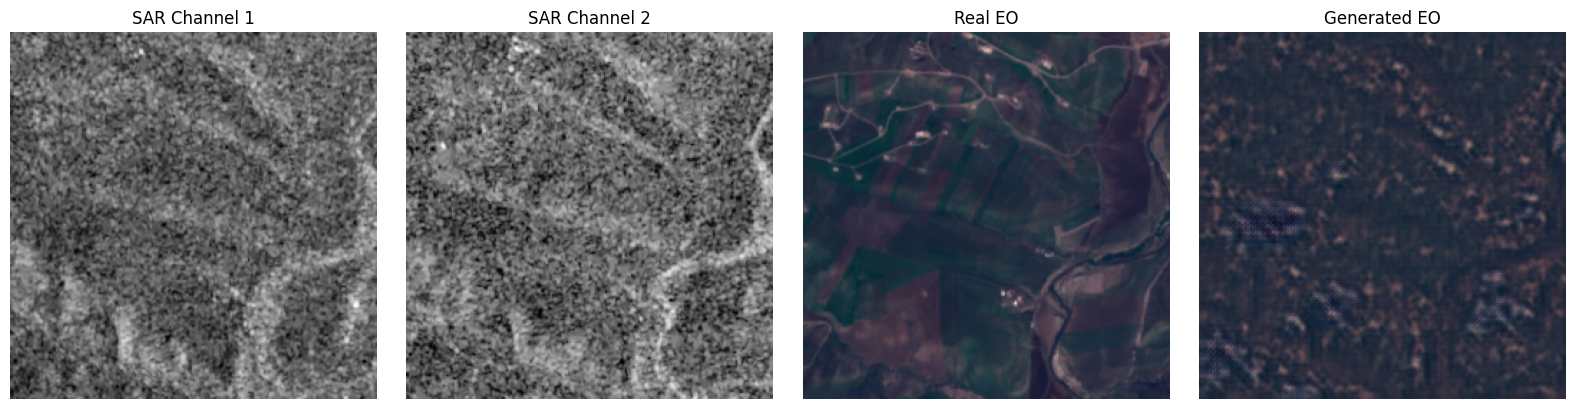

In [29]:
visualize_samples(model=G_SAR_to_EO, val_loader=val_loader, device='cuda', num_samples=5)
